# Set-Up

In [1]:
import jax
import jax.numpy as jnp
from approx_post import losses, optimisers, distributions
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

# Plotting Functions

In [2]:
def plot_data(data, true_theta, model):
    sns.scatterplot(x=true_theta.squeeze(), y=data.squeeze(), label=f"Obsevations")
    sns.lineplot(x=true_theta.squeeze(), y=model(true_theta).squeeze(), label=f"True Relationship", color='r')
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("(Noisy) Observations $x$")
    plt.show()

In [3]:
color_list = ['red', 'blue', 'yellow', 'purple', 'orange', 'pink', 'cyan']
def plot_phi_function(amortised_dist, x, x_obs=None, true_theta=None, model=None):
    # Compute phi:
    if x.ndim < 2:
        x = x[:,None]
    pred_phi = amortised_dist.phi(x)
    
    # Plot mean and standard deviation:
    x_plt = x.squeeze()
    for idx, (key, phi_i) in enumerate(pred_phi.items()):
        if 'component' in key: 
            pred_mean, pred_std = phi_i['mean'].squeeze(), jnp.exp(phi_i['log_chol_diag']).squeeze()
            mean_plus_cov = pred_mean + 2*pred_std
            mean_minus_cov = pred_mean - 2*pred_std
            ax = sns.lineplot(x=x_plt, y=pred_mean, color=color_list[idx], label=f"Predicted Mean for Component {idx+1}")
            sns.lineplot(x=x_plt, y=mean_plus_cov, color=color_list[idx], label=f"Predicted Mean Plus/Minus 2 x Standard Deviation for Component {idx+1}", linestyle='--')
            sns.lineplot(x=x_plt, y=mean_minus_cov, color=color_list[idx], linestyle='--')
            ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color=color_list[idx], alpha=0.2)
    if (data is not None) and (true_theta is not None):
        sns.scatterplot(x=data.squeeze(), y=true_theta.squeeze(), label=f"Observations", color='green') 
    if (model is not None) and (true_theta is not None):
        sns.scatterplot(x=model(true_theta.squeeze()), y=true_theta.squeeze(), label=f"True Relationship", color='black')
    plt.xlabel("Observation $x$")
    plt.ylabel("Parameter $\Theta$")
    plt.show()
    
    plt.figure()
    
    # Plot mixture coefficients:
    coeffs = amortised_dist.coefficients(x=x)
    for idx, coeff_i in enumerate(coeffs.T): 
        sns.lineplot(x=x_plt, y=coeff_i, color=color_list[idx], label=f"Mixture Coefficient for Component {idx+1}")      
    plt.xlabel("Observation $x$")
    plt.ylabel("Mixture Coefficient")
    plt.ylim(ymin = -0.05, ymax = 1.05)
    plt.show()

In [4]:
def plot_posteriors(ammortised_dist, x_list, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-4, 4, 1000)).reshape(1,-1,1)
    for x_i in x_list:
        pdf = jnp.exp(amortised_dist.logpdf(theta, x=jnp.array([[x_i]])))
        ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze(), label=f"x = {x_i:.1f}")
        ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

# Artificial Data Creation

In [5]:
def create_data(model, theta, noise_cov, prngkey):
    num_batch = theta.shape[0] 
    mean_vals = model(theta).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [6]:
# Define model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [7]:
prngkey = jax.random.PRNGKey(42)
num_batch = 100
true_theta = jnp.linspace(-5, 5, num_batch)
noise_cov = 1*jnp.identity(ndim)
data = create_data(model, true_theta, noise_cov, prngkey)

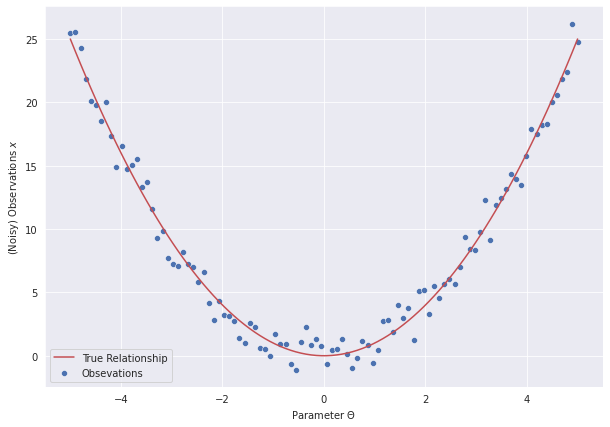

In [8]:
plot_data(data, true_theta, model)

# Create Joint Distribution

In [9]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)
joint_dist = distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Neural Network

In [18]:
prngkey = jax.random.PRNGKey(10)
approx_dist = distributions.approx.Gaussian(ndim)
mix_dist = distributions.mixture.Identical(approx_dist,2)
preprocessing = distributions.amortised.Preprocessing.std_scaling(data)
amortised_dist = distributions.amortised.NeuralNetwork(mix_dist, ndim, prngkey, num_layers=3, width=5, \
                                                       activation='sigmoid', preprocessing=preprocessing)

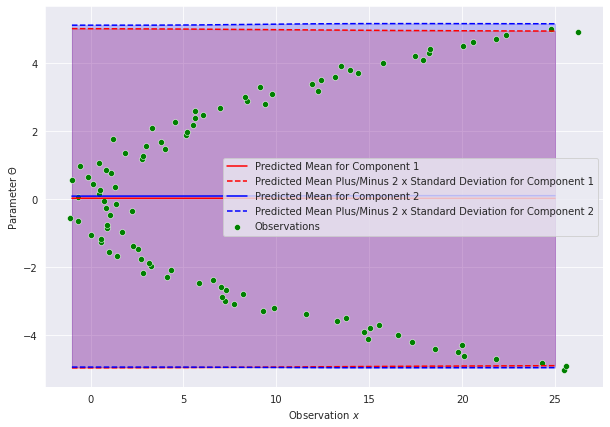

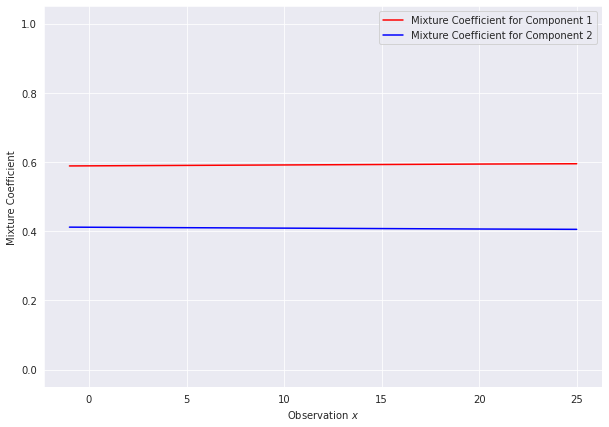

In [19]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [20]:
# Initialise:
target = Jaxtainer({'component_0': {'mean': -2.0, 'log_chol_diag': -0.5}},
                   {'component_1': {'mean': 2.0, 'log_chol_diag': -0.5}})
# target = Jaxtainer({'component_0': {'mean': 0, 'log_chol_diag': 0}})
mse = losses.MSE(target)
optimiser = optimisers.Adam(lr=5e-3)
optimiser.fit(amortised_dist, mse, data, prngkey, max_iter=100, verbose=True)

Loss = 700.79150390625, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7591358 , -0.02973867,  2.3793876 ,  1.2182703 ,
               0.40732157]], dtype=float32), 'b_0': DeviceArray([-0.00499999, -0.00499996,  0.00499998,  0.00499999,
             -0.005     ], dtype=float32), 'W_1': DeviceArray([[-0.06066358, -0.45731136, -0.57081705, -0.40556714,
               0.4293586 ],
             [-0.38993075,  1.175614  , -1.2469593 ,  0.5060226 ,
               0.08742529],
             [-0.46566457,  0.84299886,  0.12307294,  0.38274735,
              -0.33791187],
             [-0.21778592,  1.0908867 ,  0.7755841 , -0.42411828,
              -0.75266016],
             [-1.2449256 ,  0.80219656,  1.020199  ,  0.57591695,
               1.1448979 ]], dtype=float32), 'b_1': DeviceArray([ 0.005     ,  0.00499999,  0.00499999,  0.005     ,
             -0.005     ], dtype=float32), 'W_2': DeviceArray([[ 0.30121264,  0.04195708,  0.86888206, -0.57234496,
              -0.8176523 

Loss = 649.8649291992188, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.74916816, -0.03961059,  2.3694463 ,  1.2083223 ,
               0.3995122 ]], dtype=float32), 'b_0': DeviceArray([-0.01496084, -0.01501897,  0.01494846,  0.01494811,
             -0.01496666], dtype=float32), 'W_1': DeviceArray([[-0.05065433, -0.44738892, -0.56082684, -0.39555845,
               0.41940743],
             [-0.37992105,  1.1855378 , -1.2369697 ,  0.51603144,
               0.07747509],
             [-0.45565262,  0.8529274 ,  0.13306354,  0.39275798,
              -0.34786376],
             [-0.207774  ,  1.1008158 ,  0.7855755 , -0.41410753,
              -0.7626131 ],
             [-1.2349157 ,  0.8121205 ,  1.0301882 ,  0.5859259 ,
               1.1349481 ]], dtype=float32), 'b_1': DeviceArray([ 0.01501049,  0.0149253 ,  0.01499099,  0.01500971,
             -0.0149523 ], dtype=float32), 'W_2': DeviceArray([[ 0.29121995,  0.03195786,  0.87888646, -0.562334  ,
              -0.827634

Loss = 602.8793334960938, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.73928785, -0.04909085,  2.3596776 ,  1.1985242 ,
               0.39976946]], dtype=float32), 'b_0': DeviceArray([-0.02481559, -0.02508188,  0.02474722,  0.02474873,
             -0.02484432], dtype=float32), 'W_1': DeviceArray([[-0.04062271, -0.43768188, -0.5508644 , -0.38553184,
               0.4095928 ],
             [-0.36988774,  1.1952498 , -1.2270094 ,  0.5260584 ,
               0.067664  ],
             [-0.44561124,  0.86265683,  0.14302666,  0.4027911 ,
              -0.35768065],
             [-0.19773273,  1.1105466 ,  0.7955417 , -0.40407372,
              -0.77243376],
             [-1.2248818 ,  0.82183236,  1.0401472 ,  0.5959531 ,
               1.1251382 ]], dtype=float32), 'b_1': DeviceArray([ 0.02504654,  0.02464258,  0.02495603,  0.02503995,
             -0.02477087], dtype=float32), 'W_2': DeviceArray([[ 0.2812483 ,  0.02196196,  0.88894296, -0.55229735,
              -0.837568

Loss = 559.4198608398438, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.72955406, -0.05781921,  2.3502312 ,  1.188998  ,
               0.40563244]], dtype=float32), 'b_0': DeviceArray([-0.03449261, -0.03520568,  0.03427289,  0.03428788,
             -0.0345759 ], dtype=float32), 'W_1': DeviceArray([[-0.0305581 , -0.42834467, -0.54095083, -0.3754843 ,
               0.40001526],
             [-0.35981962,  1.2045975 , -1.217101  ,  0.5361063 ,
               0.05809393],
             [-0.43552575,  0.8720427 ,  0.15294008,  0.41285154,
              -0.36726254],
             [-0.18764758,  1.1199342 ,  0.8054621 , -0.39401147,
              -0.7820237 ],
             [-1.2148128 ,  0.8311784 ,  1.0500525 ,  0.6060012 ,
               1.1155704 ]], dtype=float32), 'b_1': DeviceArray([ 0.03512062,  0.03400132,  0.03487469,  0.03509504,
             -0.03435661], dtype=float32), 'W_2': DeviceArray([[ 0.2713138 ,  0.01197351,  0.89910185, -0.5422245 ,
              -0.84742 

Loss = 518.8844604492188, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.72003454, -0.06532471,  2.3413093 ,  1.179901  ,
               0.41366586]], dtype=float32), 'b_0': DeviceArray([-0.04391323, -0.04540215,  0.04336681,  0.0434267 ,
             -0.04410297], dtype=float32), 'W_1': DeviceArray([[-0.02045159, -0.41955155, -0.53111094, -0.3654178 ,
               0.3907925 ],
             [-0.34970722,  1.2134082 , -1.2072706 ,  0.5461727 ,
               0.04888363],
             [-0.42538315,  0.8809202 ,  0.16277686,  0.42293853,
              -0.37649208],
             [-0.1775057 ,  1.1288116 ,  0.8153118 , -0.3839208 ,
              -0.7912668 ],
             [-1.2046993 ,  0.83998525,  1.0598767 ,  0.61606723,
               1.1063638 ]], dtype=float32), 'b_1': DeviceArray([ 0.04524349,  0.04283011,  0.04472255,  0.04517413,
             -0.04359292], dtype=float32), 'W_2': DeviceArray([[ 0.26143554,  0.00199847,  0.9093999 , -0.5321083 ,
              -0.857153

Loss = 480.90789794921875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.71080625, -0.07107639,  2.333175  ,  1.1714311 ,
               0.42278993]], dtype=float32), 'b_0': DeviceArray([-0.05299323, -0.05567852,  0.0518307 ,  0.05200106,
             -0.05336901], dtype=float32), 'W_1': DeviceArray([[-0.01029603, -0.41148943, -0.5213728 , -0.35533914,
               0.38205808],
             [-0.33954296,  1.2214957 , -1.197548  ,  0.5562501 ,
               0.04016721],
             [-0.41517204,  0.88910985,  0.17250606,  0.43304598,
              -0.3852357 ],
             [-0.16729599,  1.1369957 ,  0.8250618 , -0.3738068 ,
              -0.80002993],
             [-1.1945337 ,  0.8480684 ,  1.0695887 ,  0.6261434 ,
               1.0976524 ]], dtype=float32), 'b_1': DeviceArray([ 0.05542419,  0.05094292,  0.05447173,  0.05527152,
             -0.05234663], dtype=float32), 'W_2': DeviceArray([[ 0.25163537, -0.00795539,  0.91986126, -0.52194494,
              -0.86672

Loss = 445.22088623046875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.70195466, -0.07460908,  2.3261514 ,  1.1638252 ,
               0.43260098]], dtype=float32), 'b_0': DeviceArray([-0.06164489, -0.06603783,  0.05942721,  0.05982487,
             -0.06232238], dtype=float32), 'W_1': DeviceArray([[-8.6029526e-05, -4.0434614e-01, -5.1176697e-01,
              -3.4525928e-01,  3.7395814e-01],
             [-3.2932112e-01,  1.2286724e+00, -1.1879658e+00,
               5.6632674e-01,  3.2090351e-02],
             [-4.0488267e-01,  8.9642751e-01,  1.8209334e-01,
               4.4316313e-01, -3.9334667e-01],
             [-1.5700921e-01,  1.1442965e+00,  8.3467990e-01,
              -3.6367941e-01, -8.0816603e-01],
             [-1.1843096e+00,  8.5524428e-01,  1.0791546e+00,
               6.3621753e-01,  1.0895820e+00]], dtype=float32), 'b_1': DeviceArray([ 0.06566995,  0.05814993,  0.06409141,  0.06537709,
             -0.06047108], dtype=float32), 'W_2': DeviceArray([

Loss = 411.5650329589844, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.693572  , -0.07567583,  2.3205984 ,  1.1573488 ,
               0.4428932 ]], dtype=float32), 'b_0': DeviceArray([-0.06977937, -0.07647927,  0.06589007,  0.06669869,
             -0.0709189 ], dtype=float32), 'W_1': DeviceArray([[ 0.010182  , -0.39829525, -0.5023261 , -0.3351929 ,
               0.3666449 ],
             [-0.31903803,  1.234764  , -1.1785582 ,  0.5763867 ,
               0.02480381],
             [-0.39450726,  0.9026976 ,  0.19150178,  0.45327473,
              -0.40067124],
             [-0.14663821,  1.1505313 ,  0.84413123, -0.35355288,
              -0.8155196 ],
             [-1.1740226 ,  0.86134475,  1.0885388 ,  0.64627355,
               1.0823026 ]], dtype=float32), 'b_1': DeviceArray([ 0.07598615,  0.06427224,  0.07354861,  0.07547676,
             -0.06781206], dtype=float32), 'W_2': DeviceArray([[ 0.2323687 , -0.02775986,  0.94132227, -0.50147897,
              -0.885235

Loss = 379.7409973144531, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.68575454, -0.07431622,  2.3168569 ,  1.1522694 ,
               0.45353198]], dtype=float32), 'b_0': DeviceArray([-0.07730946, -0.08699814,  0.07094824,  0.07242472,
             -0.07912396], dtype=float32), 'W_1': DeviceArray([[ 0.02050983, -0.39348   , -0.49308357, -0.32515788,
               0.36026776],
             [-0.30869216,  1.2396263 , -1.1693611 ,  0.58641064,
               0.01845432],
             [-0.3840402 ,  0.9077687 ,  0.20069289,  0.46336162,
              -0.40705734],
             [-0.13617808,  1.155541  ,  0.8533793 , -0.3434454 ,
              -0.82193553],
             [-1.1636695 ,  0.86623263,  1.0977045 ,  0.65629196,
               1.0759603 ]], dtype=float32), 'b_1': DeviceArray([ 0.08637621,  0.06915835,  0.08280908,  0.08555299,
             -0.07421653], dtype=float32), 'W_2': DeviceArray([[ 0.22295646, -0.03758682,  0.9523285 , -0.49118602,
              -0.894077

Loss = 349.64459228515625, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.678599  , -0.07079291,  2.315172  ,  1.1488173 ,
               0.46441168]], dtype=float32), 'b_0': DeviceArray([-0.08415227, -0.09758583,  0.07436397,  0.07682732,
             -0.08691367], dtype=float32), 'W_1': DeviceArray([[ 0.03089732, -0.3899995 , -0.48407283, -0.3151748 ,
               0.35496247],
             [-0.29828405,  1.24316   , -1.16041   ,  0.5963762 ,
               0.01317354],
             [-0.37347823,  0.91152817,  0.20962779,  0.47340125,
              -0.41236567],
             [-0.12562639,  1.1592069 ,  0.862387  , -0.33337852,
              -0.82727057],
             [-1.1532493 ,  0.8698139 ,  1.1066155 ,  0.6662505 ,
               1.0706866 ]], dtype=float32), 'b_1': DeviceArray([ 0.09684139,  0.07269913,  0.09183837,  0.09558532,
             -0.07954383], dtype=float32), 'W_2': DeviceArray([[ 0.21372998, -0.0473457 ,  0.9635137 , -0.48086497,
              -0.90258

Loss = 321.2566833496094, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6721977 , -0.06546832,  2.3156276 ,  1.1471426 ,
               0.4754391 ]], dtype=float32), 'b_0': DeviceArray([-0.09023198, -0.10822958,  0.07597555,  0.07977495,
             -0.09427507], dtype=float32), 'W_1': DeviceArray([[ 0.04134225, -0.387901  , -0.47532603, -0.3052661 ,
               0.35083938],
             [-0.2878167 ,  1.2453183 , -1.1517394 ,  0.60625875,
               0.00906696],
             [-0.3628208 ,  0.9139127 ,  0.21826841,  0.4833682 ,
              -0.4164815 ],
             [-0.11498347,  1.1614621 ,  0.8711176 , -0.3233768 ,
              -0.8314055 ],
             [-1.1427629 ,  0.87204516,  1.115237  ,  0.67612493,
               1.066587  ]], dtype=float32), 'b_1': DeviceArray([ 0.1073807 ,  0.0748375 ,  0.10060296,  0.10555089,
             -0.08367759], dtype=float32), 'W_2': DeviceArray([[ 0.2047188 , -0.05702186,  0.9748687 , -0.4705285 ,
              -0.910717

Loss = 294.6075439453125, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.66663325, -0.058708  ,  2.318134  ,  1.1472862 ,
               0.48652598]], dtype=float32), 'b_0': DeviceArray([-0.09548239, -0.11891218,  0.07572778,  0.08119766,
             -0.10120533], dtype=float32), 'W_1': DeviceArray([[ 0.05184016, -0.3871789 , -0.4668731 , -0.295456  ,
               0.34797385],
             [-0.2772955 ,  1.2461085 , -1.143381  ,  0.6160319 ,
               0.00620451],
             [-0.3520702 ,  0.9149119 ,  0.22657879,  0.49323466,
              -0.41932502],
             [-0.10425266,  1.1622962 ,  0.8795363 , -0.3134672 ,
              -0.8342565 ],
             [-1.1322134 ,  0.8729333 ,  1.1235366 ,  0.68588924,
               1.0637326 ]], dtype=float32), 'b_1': DeviceArray([ 0.11799061,  0.07557098,  0.1090713 ,  0.11542499,
             -0.08653641], dtype=float32), 'W_2': DeviceArray([[ 0.1959526 , -0.06659999,  0.9863809 , -0.46019223,
              -0.918432

Loss = 269.7288513183594, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.66197294, -0.05083529,  2.3224726 ,  1.1491783 ,
               0.49758556]], dtype=float32), 'b_0': DeviceArray([-0.09984905, -0.12961178,  0.07367659,  0.08109461,
             -0.10771017], dtype=float32), 'W_1': DeviceArray([[ 0.06238417, -0.38778076, -0.45874074, -0.28576946,
               0.34640023],
             [-0.26672852,  1.2455856 , -1.1353638 ,  0.6256681 ,
               0.0046153 ],
             [-0.34123185,  0.91456497,  0.23452634,  0.50297135,
              -0.4208583 ],
             [-0.09344043,  1.1617516 ,  0.8876111 , -0.30367848,
              -0.8357823 ],
             [-1.1216062 ,  0.87253   ,  1.1314857 ,  0.6955166 ,
               1.0621544 ]], dtype=float32), 'b_1': DeviceArray([ 0.12866484,  0.07494687,  0.11721486,  0.12518157,
             -0.08808075], dtype=float32), 'W_2': DeviceArray([[ 1.8746074e-01, -7.6064467e-02,  9.9803424e-01,
              -4.4987431e-0

Loss = 246.60743713378906, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.658264  , -0.04212127,  2.3283598 ,  1.1526617 ,
               0.50853115]], dtype=float32), 'b_0': DeviceArray([-0.10329125, -0.14030159,  0.06996775,  0.07952955,
             -0.1138017 ], dtype=float32), 'W_1': DeviceArray([[ 0.07296479, -0.38961747, -0.45095167, -0.27623218,
               0.3461107 ],
             [-0.25612658,  1.2438416 , -1.1277122 ,  0.6351391 ,
               0.00428702],
             [-0.3303143 ,  0.91295165,  0.242083  ,  0.5125479 ,
              -0.42108655],
             [-0.08255656,  1.159914  ,  0.89531404, -0.29404062,
              -0.8359869 ],
             [-1.1109498 ,  0.8709217 ,  1.1390601 ,  0.7049794 ,
               1.0618427 ]], dtype=float32), 'b_1': DeviceArray([ 0.13939421,  0.07305241,  0.12500897,  0.1347937 ,
             -0.08831487], dtype=float32), 'W_2': DeviceArray([[ 0.1792718 , -0.08539959,  1.0098099 , -0.43959504,
              -0.93246

Loss = 225.1641387939453, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.65552926, -0.03279012,  2.3355012 ,  1.1575271 ,
               0.5192758 ]], dtype=float32), 'b_0': DeviceArray([-0.10578347, -0.1509499 ,  0.06480238,  0.07661734,
             -0.1194962 ], dtype=float32), 'W_1': DeviceArray([[ 0.08356977, -0.39257482, -0.44352418, -0.26686987,
               0.34705898],
             [-0.24550343,  1.240994  , -1.1204458 ,  0.6444166 ,
               0.00517001],
             [-0.3193294 ,  0.9101811 ,  0.24922611,  0.52193373,
              -0.42005512],
             [-0.0716142 ,  1.1569    ,  0.90262216, -0.2845841 ,
              -0.8349158 ],
             [-1.100255  ,  0.8682188 ,  1.1462408 ,  0.71425027,
               1.062751  ]], dtype=float32), 'b_1': DeviceArray([ 0.15016642,  0.07000273,  0.13243344,  0.14423403,
             -0.0872835 ], dtype=float32), 'W_2': DeviceArray([[ 0.17141336, -0.09458994,  1.0216863 , -0.4293767 ,
              -0.938721

Loss = 205.2704315185547, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6537657 , -0.02302855,  2.343621  ,  1.1635444 ,
               0.52973276]], dtype=float32), 'b_0': DeviceArray([-0.10731622, -0.16152024,  0.05840402,  0.07250634,
             -0.12481184], dtype=float32), 'W_1': DeviceArray([[ 0.09418401, -0.39652434, -0.4364718 , -0.257708  ,
               0.34916747],
             [-0.23487572,  1.2371742 , -1.1135792 ,  0.65347254,
               0.00718454],
             [-0.3082924 ,  0.9063801 ,  0.25593898,  0.5310986 ,
              -0.4178419 ],
             [-0.06062986,  1.1528444 ,  0.90951777, -0.27533948,
              -0.83264893],
             [-1.0895362 ,  0.86454576,  1.1530141 ,  0.72330207,
               1.0648031 ]], dtype=float32), 'b_1': DeviceArray([ 0.16096602,  0.06592919,  0.13947293,  0.15347525,
             -0.08506471], dtype=float32), 'W_2': DeviceArray([[ 0.16391161, -0.10362066,  1.0336397 , -0.41924286,
              -0.944438

Loss = 186.7906951904297, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6529442 , -0.01299434,  2.3524737 ,  1.1704855 ,
               0.53981715]], dtype=float32), 'b_0': DeviceArray([-0.10789637, -0.17197174,  0.05099508,  0.06736182,
             -0.12976687], dtype=float32), 'W_1': DeviceArray([[ 0.10478959, -0.40133217, -0.4298034 , -0.24877152,
               0.35233596],
             [-0.22426307,  1.2325187 , -1.1071211 ,  0.66227996,
               0.01022936],
             [-0.29722166,  0.90168357,  0.26221126,  0.54001325,
              -0.41454864],
             [-0.04962336,  1.1478895 ,  0.915989  , -0.2663365 ,
              -0.8292908 ],
             [-1.0788103 ,  0.86003244,  1.1593716 ,  0.7321088 ,
               1.0679005 ]], dtype=float32), 'b_1': DeviceArray([ 0.17177437,  0.06096984,  0.14611703,  0.16249049,
             -0.0817608 ], dtype=float32), 'W_2': DeviceArray([[ 0.15679118, -0.11247779,  1.0456438 , -0.40921813,
              -0.949600

Loss = 169.61907958984375, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.65301216, -0.00282282,  2.3618448 ,  1.178136  ,
               0.5494481 ]], dtype=float32), 'b_0': DeviceArray([-0.10754668, -0.1822598 ,  0.04278368,  0.06135292,
             -0.13437818], dtype=float32), 'W_1': DeviceArray([[ 0.11536583, -0.40686554, -0.42352346, -0.24008444,
               0.35645035],
             [-0.2136878 ,  1.2271627 , -1.1010759 ,  0.670813  ,
               0.01419016],
             [-0.2861389 ,  0.8962269 ,  0.2680387 ,  0.54865   ,
              -0.41029164],
             [-0.03861764,  1.1421776 ,  0.92202973, -0.2576037 ,
              -0.8249613 ],
             [-1.0680976 ,  0.85480803,  1.1653103 ,  0.7406454 ,
               1.0719316 ]], dtype=float32), 'b_1': DeviceArray([ 0.18256974,  0.05526229,  0.1523601 ,  0.17125367,
             -0.07748914], dtype=float32), 'W_2': DeviceArray([[ 0.1500749 , -0.12114853,  1.0576706 , -0.39932743,
              -0.95419

Loss = 153.68850708007812, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.65389675,  0.00736882,  2.3715475 ,  1.1863009 ,
               0.5585511 ]], dtype=float32), 'b_0': DeviceArray([-0.1063047 , -0.19233707,  0.03395814,  0.05464383,
             -0.13866049], dtype=float32), 'W_1': DeviceArray([[ 0.12588945, -0.41299683, -0.41763234, -0.23166965,
               0.36139005],
             [-0.20317478,  1.2212359 , -1.0954429 ,  0.6790475 ,
               0.01894685],
             [-0.2750687 ,  0.89014125,  0.27342287,  0.55698323,
              -0.40519413],
             [-0.02763852,  1.1358454 ,  0.9276394 , -0.24916786,
              -0.8197872 ],
             [-1.057421  ,  0.84899706,  1.1708318 ,  0.7488887 ,
               1.0767783 ]], dtype=float32), 'b_1': DeviceArray([ 0.19332752,  0.04893906,  0.1582009 ,  0.1797399 ,
             -0.07237411], dtype=float32), 'W_2': DeviceArray([[ 0.14378361, -0.12962143,  1.0696902 , -0.38959548,
              -0.95821

Loss = 138.95545959472656, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.65551   ,  0.01747894,  2.3814194 ,  1.1948061 ,
               0.56706154]], dtype=float32), 'b_0': DeviceArray([-0.10422094, -0.20215458,  0.02468602,  0.04738867,
             -0.14262594], dtype=float32), 'W_1': DeviceArray([[ 0.1363349 , -0.41960624, -0.4121271 , -0.22354865,
               0.36703396],
             [-0.19275108,  1.2148595 , -1.0902174 ,  0.6869615 ,
               0.02437904],
             [-0.26403847,  0.88355047,  0.27837056,  0.5649896 ,
              -0.39938015],
             [-0.01671442,  1.1290215 ,  0.93282217, -0.24105352,
              -0.8138959 ],
             [-1.046806  ,  0.8427168 ,  1.1759421 ,  0.75681716,
               1.0823218 ]], dtype=float32), 'b_1': DeviceArray([ 0.2040205 ,  0.04212477,  0.1636421 ,  0.18792585,
             -0.06654095], dtype=float32), 'W_2': DeviceArray([[ 0.1379361 , -0.1378867 ,  1.0816715 , -0.3800464 ,
              -0.96166

Loss = 125.37958526611328, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6577536 ,  0.02741994,  2.3913198 ,  1.2034981 ,
               0.5749276 ]], dtype=float32), 'b_0': DeviceArray([-0.10135671, -0.21166317,  0.01511514,  0.03972879,
             -0.1462842 ], dtype=float32), 'W_1': DeviceArray([[ 0.14667471, -0.4265829 , -0.4070021 , -0.2157414 ,
               0.3732645 ],
             [-0.1824455 ,  1.2081455 , -1.0853914 ,  0.6945351 ,
               0.03037011],
             [-0.25307798,  0.8765692 ,  0.2828929 ,  0.57264876,
              -0.39297011],
             [-0.00587587,  1.1218245 ,  0.93758637, -0.23328263,
              -0.8074108 ],
             [-1.0362805 ,  0.836076  ,  1.1806505 ,  0.7644116 ,
               1.0884464 ]], dtype=float32), 'b_1': DeviceArray([ 0.21461934,  0.03493475,  0.16868956,  0.19578989,
             -0.0601113 ], dtype=float32), 'W_2': DeviceArray([[ 0.13254881, -0.1459363 ,  1.093582  , -0.37070304,
              -0.96454

Loss = 112.91146087646484, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6605238 ,  0.03711759,  2.4011269 ,  1.2122436 ,
               0.58211297]], dtype=float32), 'b_0': DeviceArray([-0.09778158, -0.220815  ,  0.00537536,  0.03179186,
             -0.14964284], dtype=float32), 'W_1': DeviceArray([[ 0.15687999, -0.43382546, -0.40224952, -0.20826605,
               0.37997025],
             [-0.17228805,  1.2011958 , -1.0809542 ,  0.7017512 ,
               0.03680968],
             [-0.24221897,  0.86930263,  0.2870046 ,  0.5799431 ,
              -0.3860784 ],
             [ 0.00484492,  1.1143622 ,  0.9419438 , -0.22587426,
              -0.80044866],
             [-1.025874  ,  0.8291743 ,  1.184969  ,  0.7716553 ,
               1.0950419 ]], dtype=float32), 'b_1': DeviceArray([ 0.22509302,  0.02747445,  0.1733517 ,  0.20331253,
             -0.05320043], dtype=float32), 'W_2': DeviceArray([[ 0.12763579, -0.153764  ,  1.1053888 , -0.36158663,
              -0.96687

Loss = 101.4898910522461, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.66371584,  0.04651054,  2.4107368 ,  1.2209276 ,
               0.5885986 ]], dtype=float32), 'b_0': DeviceArray([-0.09357093, -0.22956507, -0.00441973,  0.02369162,
             -0.15270811], dtype=float32), 'W_1': DeviceArray([[ 0.16692097, -0.44124207, -0.39786023, -0.20113887,
               0.3870476 ],
             [-0.16230935,  1.1941024 , -1.0768931 ,  0.7085954 ,
               0.04359521],
             [-0.2314946 ,  0.86184615,  0.2907228 ,  0.58685833,
              -0.3788114 ],
             [ 0.01541467,  1.1067322 ,  0.94590884, -0.2188444 ,
              -0.79311794],
             [-1.0156174 ,  0.82210183,  1.1889113 ,  0.778534  ,
               1.1020058 ]], dtype=float32), 'b_1': DeviceArray([ 0.23540948,  0.01983942,  0.17763883,  0.21047656,
             -0.04591559], dtype=float32), 'W_2': DeviceArray([[ 0.12320852, -0.1613655 ,  1.1170583 , -0.35271636,
              -0.968667

Loss = 91.04533386230469, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6672277 ,  0.05554994,  2.4200642 ,  1.2294539 ,
               0.59438384]], dtype=float32), 'b_0': DeviceArray([-0.08880348, -0.2378728 , -0.01417136,  0.01552828,
             -0.15548557], dtype=float32), 'W_1': DeviceArray([[ 0.1767676 , -0.4487501 , -0.39382413, -0.19437398,
               0.3944013 ],
             [-0.15254   ,  1.1869472 , -1.073194  ,  0.7150563 ,
               0.05063271],
             [-0.22093885,  0.8542855 ,  0.29406643,  0.59338325,
              -0.37126702],
             [ 0.02579963,  1.0990216 ,  0.9494976 , -0.21220581,
              -0.78551793],
             [-1.0055419 ,  0.8149398 ,  1.1924931 ,  0.785036  ,
               1.1092435 ]], dtype=float32), 'b_1': DeviceArray([ 0.24553627,  0.01211553,  0.18156247,  0.21726727,
             -0.03835518], dtype=float32), 'W_2': DeviceArray([[ 0.11927567, -0.1687383 ,  1.1285572 , -0.344109  ,
              -0.969938

Loss = 81.5057601928711, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6709629 ,  0.06419888,  2.4290397 ,  1.2377436 ,
               0.59948575]], dtype=float32), 'b_0': DeviceArray([-0.08355917, -0.24570331, -0.02379456,  0.00738899,
             -0.157981  ], dtype=float32), 'W_1': DeviceArray([[ 0.18639022, -0.4562759 , -0.3901308 , -0.18798332,
               0.40194502],
             [-0.14300987,  1.1798025 , -1.0698425 ,  0.7211253 ,
               0.05783708],
             [-0.2105858 ,  0.8466971 ,  0.29705533,  0.59950995,
              -0.36353436],
             [ 0.03596632,  1.0913075 ,  0.9527271 , -0.20596795,
              -0.77773863],
             [-0.99567914,  0.80776054,  1.1957299 ,  0.7911526 ,
               1.1166688 ]], dtype=float32), 'b_1': DeviceArray([ 0.2554412 ,  0.00437935,  0.18513487,  0.22367263,
             -0.03060856], dtype=float32), 'W_2': DeviceArray([[ 0.11584304, -0.1758817 ,  1.1398528 , -0.33577883,
              -0.9707157

Loss = 72.80364227294922, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6748331 ,  0.07243156,  2.4376106 ,  1.2457341 ,
               0.6039378 ]], dtype=float32), 'b_0': DeviceArray([-0.0779173 , -0.2530287 , -0.03321722, -0.00065152,
             -0.16020103], dtype=float32), 'W_1': DeviceArray([[ 0.19576022, -0.4637542 , -0.3867697 , -0.18197642,
               0.40960103],
             [-0.13374749,  1.1727314 , -1.0668232 ,  0.7267969 ,
               0.06513202],
             [-0.20046902,  0.8391487 ,  0.2997096 ,  0.60523355,
              -0.35569373],
             [ 0.0458822 ,  1.0836579 ,  0.95561504, -0.20013699,
              -0.769861  ],
             [-0.9860596 ,  0.8006279 ,  1.1986377 ,  0.7968777 ,
               1.1242039 ]], dtype=float32), 'b_1': DeviceArray([ 0.26509315, -0.00330147,  0.1883686 ,  0.22968335,
             -0.02275605], dtype=float32), 'W_2': DeviceArray([[ 0.11291333, -0.18279652,  1.1509134 , -0.3277375 ,
              -0.971025

Loss = 64.88009643554688, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6787594 ,  0.08023217,  2.4457397 ,  1.2533779 ,
               0.6077872 ]], dtype=float32), 'b_0': DeviceArray([-0.07195501, -0.25982866, -0.04237947, -0.00853033,
             -0.1621538 ], dtype=float32), 'W_1': DeviceArray([[ 0.20485069, -0.47112787, -0.38373047, -0.17636032,
               0.41730005],
             [-0.12477931,  1.1657885 , -1.0641212 ,  0.7320687 ,
               0.07244986],
             [-0.1906207 ,  0.83169967,  0.302049  ,  0.61055243,
              -0.34781682],
             [ 0.05551636,  1.0761317 ,  0.958179  , -0.19471584,
              -0.7619569 ],
             [-0.97671247,  0.7935975 ,  1.2012327 ,  0.802208  ,
               1.1317793 ]], dtype=float32), 'b_1': DeviceArray([ 0.27446273, -0.01086775,  0.19127627,  0.23529308,
             -0.01486922], dtype=float32), 'W_2': DeviceArray([[ 0.11048602, -0.18948504,  1.1617086 , -0.31999394,
              -0.970898

Loss = 57.68444061279297, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6826737 ,  0.08759359,  2.453404  ,  1.2606419 ,
               0.6110915 ]], dtype=float32), 'b_0': DeviceArray([-0.06574608, -0.26609105, -0.05123295, -0.01619556,
             -0.16384931], dtype=float32), 'W_1': DeviceArray([[ 0.21363698, -0.4783474 , -0.3810029 , -0.17113942,
               0.42498088],
             [-0.11612918,  1.1590203 , -1.0617219 ,  0.73694116,
               0.07973117],
             [-0.18107107,  0.8244013 ,  0.30409274,  0.61546785,
              -0.3399672 ],
             [ 0.06484029,  1.0687796 ,  0.9604363 , -0.18970427,
              -0.7540897 ],
             [-0.9676648 ,  0.78671753,  1.2035298 ,  0.8071431 ,
               1.1393336 ]], dtype=float32), 'b_1': DeviceArray([ 0.2835229 , -0.0182684 ,  0.19387028,  0.24049841,
             -0.00701124], dtype=float32), 'W_2': DeviceArray([[ 0.10855721, -0.19595069,  1.1722103 , -0.31255445,
              -0.970365

Loss = 51.16967010498047, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.68651897,  0.09451606,  2.4605927 ,  1.2675052 ,
               0.6139154 ]], dtype=float32), 'b_0': DeviceArray([-0.05936001, -0.27181193, -0.05974016, -0.02360568,
             -0.1652996 ], dtype=float32), 'W_1': DeviceArray([[ 0.2220973 , -0.48537055, -0.37857705, -0.16631545,
               0.43259004],
             [-0.10781787,  1.1524653 , -1.0596106 ,  0.7414176 ,
               0.08692446],
             [-0.1718476 ,  0.8172975 ,  0.30585912,  0.6199839 ,
              -0.33220044],
             [ 0.07382837,  1.0616442 ,  0.9624036 , -0.18509899,
              -0.7463148 ],
             [-0.95894074,  0.78002876,  1.205544  ,  0.8116852 ,
               1.1468129 ]], dtype=float32), 'b_1': DeviceArray([ 0.2922497 , -0.02545995,  0.19616286,  0.2452989 ,
              0.00076274], dtype=float32), 'W_2': DeviceArray([[ 0.10711957, -0.20219773,  1.1823928 , -0.3054228 ,
              -0.969459

Loss = 45.28836441040039, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6902491 ,  0.10100566,  2.4673061 ,  1.2739574 ,
               0.6163271 ]], dtype=float32), 'b_0': DeviceArray([-0.05286133, -0.27699515, -0.06787363, -0.03072861,
             -0.16651876], dtype=float32), 'W_1': DeviceArray([[ 0.23021315, -0.49216196, -0.37644297, -0.16188736,
               0.4400813 ],
             [-0.09986261,  1.1461549 , -1.0577731 ,  0.745504  ,
               0.09398567],
             [-0.16297449,  0.81042504,  0.30736548,  0.6241074 ,
              -0.32456473],
             [ 0.0824585 ,  1.0547608 ,  0.96409714, -0.18089384,
              -0.7386797 ],
             [-0.95056146,  0.7735652 ,  1.2072896 ,  0.8158393 ,
               1.1541706 ]], dtype=float32), 'b_1': DeviceArray([ 0.30062255, -0.0324062 ,  0.19816613,  0.24969713,
              0.00840518], dtype=float32), 'W_2': DeviceArray([[ 0.10616229, -0.2082311 ,  1.1922331 , -0.29860052,
              -0.968215

Loss = 39.99152755737305, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.6938287,  0.107073 ,  2.4735532,  1.2799971,  0.6183951]],            dtype=float32), 'b_0': DeviceArray([-0.04630914, -0.2816518 , -0.075615  , -0.03754087,
             -0.16752277], dtype=float32), 'W_1': DeviceArray([[ 0.23796956, -0.49869266, -0.3745907 , -0.15785132,
               0.44741526],
             [-0.09227686,  1.140114  , -1.0561957 ,  0.74920917,
               0.10087772],
             [-0.15447217,  0.80381393,  0.30862817,  0.6278477 ,
              -0.31710106],
             [ 0.09071244,  1.0481577 ,  0.9655325 , -0.17707996,
              -0.73122466],
             [-0.9425443 ,  0.76735437,  1.2087802 ,  0.81961274,
               1.1613672 ]], dtype=float32), 'b_1': DeviceArray([ 0.30862474, -0.03907772,  0.19989209,  0.25369853,
              0.0158757 ], dtype=float32), 'W_2': DeviceArray([[ 0.10567106, -0.2140561 ,  1.2017112 , -0.29208696,
              -0.96666735],
   

Loss = 35.23014831542969, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.69723207,  0.11273208,  2.4793496 ,  1.2856302 ,
               0.6201851 ]], dtype=float32), 'b_0': DeviceArray([-0.03975683, -0.28579935, -0.08295409, -0.04402665,
             -0.16832912], dtype=float32), 'W_1': DeviceArray([[ 0.24535538, -0.5049398 , -0.3730099 , -0.15420075,
               0.45455897],
             [-0.08507013,  1.134361  , -1.0548648 ,  0.752544  ,
               0.10757008],
             [-0.14635696,  0.79748803,  0.30966276,  0.63121617,
              -0.30984372],
             [ 0.09857614,  1.0418568 ,  0.96672463, -0.173646  ,
              -0.7239832 ],
             [-0.9349027 ,  0.7614179 ,  1.2100291 ,  0.82301533,
               1.1683693 ]], dtype=float32), 'b_1': DeviceArray([ 0.31624368, -0.04545149,  0.2013529 ,  0.25731137,
              0.02314065], dtype=float32), 'W_2': DeviceArray([[ 0.10562822, -0.21967812,  1.2108105 , -0.28587967,
              -0.964849

Loss = 30.957475662231445, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.70044214,  0.11799919,  2.4847162 ,  1.290868  ,
               0.6217581 ]], dtype=float32), 'b_0': DeviceArray([-0.03325195, -0.28946057, -0.08988772, -0.05017684,
             -0.16895643], dtype=float32), 'W_1': DeviceArray([[ 0.25236335, -0.51088613, -0.37168974, -0.15092637,
               0.46148536],
             [-0.07824803,  1.1289092 , -1.0537666 ,  0.7555218 ,
               0.11403821],
             [-0.13864085,  0.79146534,  0.31048402,  0.63422644,
              -0.30282074],
             [ 0.10603981,  1.0358739 ,  0.9676882 , -0.17057838,
              -0.7169825 ],
             [-0.92764616,  0.75577205,  1.2110497 ,  0.82605916,
               1.17515   ]], dtype=float32), 'b_1': DeviceArray([ 0.3234709 , -0.05151041,  0.20256096,  0.26054662,
              0.0301726 ], dtype=float32), 'W_2': DeviceArray([[ 0.10601281, -0.22510244,  1.2195182 , -0.27997458,
              -0.96279

Loss = 27.130373001098633, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7034494 ,  0.12289219,  2.4896772 ,  1.2957262 ,
               0.6231685 ]], dtype=float32), 'b_0': DeviceArray([-0.02683618, -0.29266244, -0.09641868, -0.05598807,
             -0.1694239 ], dtype=float32), 'W_1': DeviceArray([[ 0.25899   , -0.51651967, -0.37061867, -0.1480163 ,
               0.46817285],
             [-0.07181229,  1.1237665 , -1.0528877 ,  0.7581577 ,
               0.12026309],
             [-0.13133146,  0.7857585 ,  0.3111062 ,  0.6368939 ,
              -0.29605427],
             [ 0.11309797,  1.0302197 ,  0.9684377 , -0.16786146,
              -0.7102437 ],
             [-0.9207799 ,  0.75042766,  1.211855  ,  0.8287583 ,
               1.1816878 ]], dtype=float32), 'b_1': DeviceArray([ 0.33030206, -0.05724288,  0.20352915,  0.26341772,
              0.03694993], dtype=float32), 'W_2': DeviceArray([[ 0.10680082, -0.230334  ,  1.2278247 , -0.27436626,
              -0.96054

Loss = 23.709959030151367, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7062506 ,  0.12742987,  2.4942582 ,  1.3002228 ,
               0.62446326]], dtype=float32), 'b_0': DeviceArray([-0.02054545, -0.2954351 , -0.10255457, -0.06146176,
             -0.16975084], dtype=float32), 'W_1': DeviceArray([[ 0.2652355 , -0.52183324, -0.3697842 , -0.14545622,
               0.4746049 ],
             [-0.06576101,  1.1189364 , -1.0522139 ,  0.7604686 ,
               0.12623067],
             [-0.12443209,  0.7803752 ,  0.31154317,  0.6392356 ,
              -0.28956118],
             [ 0.11974927,  1.0248995 ,  0.96898746, -0.16547789,
              -0.7037827 ],
             [-0.9143053 ,  0.74539113,  1.2124584 ,  0.8311287 ,
               1.1879663 ]], dtype=float32), 'b_1': DeviceArray([ 0.33673686, -0.06264231,  0.20427093,  0.2659404 ,
              0.04345626], dtype=float32), 'W_2': DeviceArray([[ 0.10796548, -0.2353773 ,  1.2357242 , -0.2690482 ,
              -0.95811

Loss = 20.66132164001465, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7088473 ,  0.13163148,  2.4984856 ,  1.3043776 ,
               0.62568074]], dtype=float32), 'b_0': DeviceArray([-0.01441014, -0.2978107 , -0.10830677, -0.06660328,
             -0.1699562 ], dtype=float32), 'W_1': DeviceArray([[ 0.2711035 , -0.52682406, -0.36917293, -0.1432296 ,
               0.4807695 ],
             [-0.06008896,  1.1144183 , -1.0517312 ,  0.76247305,
               0.13193136],
             [-0.117942  ,  0.77531856,  0.31180862,  0.64126986,
              -0.28335342],
             [ 0.12599628,  1.0199145 ,  0.9693518 , -0.16340882,
              -0.69761056],
             [-0.9082202 ,  0.7406646 ,  1.2128733 ,  0.833188  ,
               1.1939738 ]], dtype=float32), 'b_1': DeviceArray([ 0.34277862, -0.06770667,  0.20480043,  0.26813242,
              0.04967999], dtype=float32), 'W_2': DeviceArray([[ 0.10947748, -0.24023624,  1.2432145 , -0.26401305,
              -0.955549

Loss = 17.95220375061035, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.71124494,  0.13551646,  2.5023859 ,  1.3082112 ,
               0.62685126]], dtype=float32), 'b_0': DeviceArray([-0.00845539, -0.2998226 , -0.1136894 , -0.07142108,
             -0.17005812], dtype=float32), 'W_1': DeviceArray([[ 0.27660063, -0.5314934 , -0.36877024, -0.1413179 ,
               0.4866586 ],
             [-0.05478795,  1.1102079 , -1.0514252 ,  0.76419073,
               0.13735951],
             [-0.11185662,  0.7705879 ,  0.31191614,  0.6430161 ,
              -0.27743858],
             [ 0.1318451 ,  1.0152619 ,  0.9695453 , -0.16163418,
              -0.6917341 ],
             [-0.9025187 ,  0.73624647,  1.2131135 ,  0.83495516,
               1.1997027 ]], dtype=float32), 'b_1': DeviceArray([ 0.34843406, -0.07243803,  0.20513257,  0.2700133 ,
              0.05561379], dtype=float32), 'W_2': DeviceArray([[ 0.11130539, -0.24491408,  1.2502962 , -0.25925267,
              -0.952874

Loss = 15.551727294921875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7134517 ,  0.13910428,  2.505984  ,  1.3117448 ,
               0.62799704]], dtype=float32), 'b_0': DeviceArray([-0.00270137, -0.3015044 , -0.1187185 , -0.07592597,
             -0.17007354], dtype=float32), 'W_1': DeviceArray([[ 0.28173625, -0.53584605, -0.36856055, -0.13970086,
               0.49226788],
             [-0.0498472 ,  1.1062982 , -1.0512809 ,  0.7656422 ,
               0.14251289],
             [-0.10616806,  0.7661788 ,  0.31187934,  0.6444946 ,
              -0.27182043],
             [ 0.13730498,  1.0109353 ,  0.9695826 , -0.16013296,
              -0.6861563 ],
             [-0.8971921 ,  0.7321318 ,  1.2131935 ,  0.8364502 ,
               1.2051494 ]], dtype=float32), 'b_1': DeviceArray([ 0.3537128 , -0.07684206,  0.20528303,  0.27160403,
              0.06125402], dtype=float32), 'W_2': DeviceArray([[ 0.11341604, -0.24941339,  1.2569734 , -0.25475854,
              -0.95011

Loss = 13.430012702941895, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.71547747,  0.14241418,  2.5093038 ,  1.3149987 ,
               0.6291327 ]], dtype=float32), 'b_0': DeviceArray([ 0.00283623, -0.30288935, -0.12341124, -0.08013047,
             -0.17001793], dtype=float32), 'W_1': DeviceArray([[ 0.28652206, -0.5398898 , -0.3685272 , -0.13835679,
               0.49759594],
             [-0.04525386,  1.1026795 , -1.0512829 ,  0.7668488 ,
               0.14739217],
             [-0.10086549,  0.7620838 ,  0.31171194,  0.6457263 ,
              -0.26649934],
             [ 0.14238779,  1.0069255 ,  0.9694786 , -0.15888351,
              -0.6808768 ],
             [-0.89222926,  0.7283127 ,  1.213128  ,  0.83769417,
               1.2103131 ]], dtype=float32), 'b_1': DeviceArray([ 0.35862693, -0.08092757,  0.20526819,  0.27292672,
              0.06660034], dtype=float32), 'W_2': DeviceArray([[ 0.11577491, -0.25373608,  1.2632527 , -0.25052175,
              -0.94730

Loss = 11.559072494506836, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.71733326,  0.14546521,  2.5123668 ,  1.3179928 ,
               0.6302662 ]], dtype=float32), 'b_0': DeviceArray([ 0.00814586, -0.3040097 , -0.1277853 , -0.08404823,
             -0.16990511], dtype=float32), 'W_1': DeviceArray([[ 0.29097146, -0.54363537, -0.3686526 , -0.13726294,
               0.5026441 ],
             [-0.04099334,  1.0993397 , -1.0514157 ,  0.7678323 ,
               0.15200052],
             [-0.09593565,  0.7582928 ,  0.31142774,  0.6467324 ,
              -0.26147288],
             [ 0.14710766,  1.0032207 ,  0.9692485 , -0.1578638 ,
              -0.6758925 ],
             [-0.88761675,  0.72477883,  1.2129319 ,  0.8387085 ,
               1.2151958 ]], dtype=float32), 'b_1': DeviceArray([ 0.36319056, -0.08470604,  0.20510508,  0.2740043 ,
              0.0716551 ], dtype=float32), 'W_2': DeviceArray([[ 0.11834659, -0.2578835 ,  1.2691433 , -0.24653314,
              -0.94445

Loss = 9.9136323928833, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7190304 ,  0.14827608,  2.5151927 ,  1.3207458 ,
               0.63139963]], dtype=float32), 'b_0': DeviceArray([ 0.0132196 , -0.3048965 , -0.13185832, -0.08769361,
             -0.16974716], dtype=float32), 'W_1': DeviceArray([[ 0.2950994 , -0.5470955 , -0.3689185 , -0.13639578,
               0.507416  ],
             [-0.03704983,  1.0962653 , -1.0516634 ,  0.76861453,
               0.1563431 ],
             [-0.09136335,  0.75479347,  0.31104064,  0.6475342 ,
              -0.2567362 ],
             [ 0.15148036,  0.99980736,  0.96890736, -0.15705164,
              -0.671198  ],
             [-0.8833396 ,  0.7215179 ,  1.2126209 ,  0.83951515,
               1.2198018 ]], dtype=float32), 'b_1': DeviceArray([ 0.36741933, -0.08819114,  0.20481123,  0.27486023,
              0.076423  ], dtype=float32), 'W_2': DeviceArray([[ 0.12109517, -0.26185638,  1.2746565 , -0.2427835 ,
              -0.94160503

Loss = 8.471122741699219, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.72058016,  0.15086512,  2.5177994 ,  1.3232757 ,
               0.6325302 ]], dtype=float32), 'b_0': DeviceArray([ 0.01805274, -0.305579  , -0.13564762, -0.09108122,
             -0.1695543 ], dtype=float32), 'W_1': DeviceArray([[ 0.2989218 , -0.5502848 , -0.36930606, -0.1357314 ,
               0.51191705],
             [-0.03340665,  1.0934414 , -1.0520103 ,  0.76921743,
               0.16042672],
             [-0.08713193,  0.75157166,  0.31056458,  0.6481529 ,
              -0.25228253],
             [ 0.15552296,  0.99666995,  0.9684706 , -0.15642501,
              -0.6667862 ],
             [-0.87938154,  0.718516  ,  1.2122103 ,  0.84013593,
               1.2241372 ]], dtype=float32), 'b_1': DeviceArray([ 0.37133   , -0.0913983 ,  0.20440446,  0.2755181 ,
              0.08091056], dtype=float32), 'W_2': DeviceArray([[ 0.12398475, -0.26565516,  1.2798052 , -0.23926355,
              -0.938760

Loss = 7.211028575897217, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7219935 ,  0.15325023,  2.5202029 ,  1.325599  ,
               0.6336513 ]], dtype=float32), 'b_0': DeviceArray([ 0.02264334, -0.30608472, -0.13916981, -0.09422568,
             -0.16933502], dtype=float32), 'W_1': DeviceArray([[ 0.30245516, -0.5532194 , -0.3697962 , -0.13524577,
               0.51615405],
             [-0.03004663,  1.0908518 , -1.0524404 ,  0.76966244,
               0.1642594 ],
             [-0.08322373,  0.74861205,  0.31001338,  0.64860934,
              -0.24810359],
             [ 0.1592533 ,  0.993792  ,  0.9679532 , -0.15596229,
              -0.66264826],
             [-0.87572557,  0.71575785,  1.2117159 ,  0.84059256,
               1.2282097 ]], dtype=float32), 'b_1': DeviceArray([ 0.37494   , -0.09434427,  0.2039027 ,  0.27600136,
              0.08512578], dtype=float32), 'W_2': DeviceArray([[ 0.12697981, -0.2692799 ,  1.2846037 , -0.23596407,
              -0.935944

Loss = 6.114380359649658, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7232807 ,  0.15544878,  2.522417  ,  1.3277313 ,
               0.63475347]], dtype=float32), 'b_0': DeviceArray([ 0.0269918 , -0.30643913, -0.14244069, -0.09714139,
             -0.16909617], dtype=float32), 'W_1': DeviceArray([[ 0.30571637, -0.5559162 , -0.3703698 , -0.13491517,
               0.5201349 ],
             [-0.02695245,  1.0884802 , -1.0529382 ,  0.76997054,
               0.16785014],
             [-0.07962049,  0.74589825,  0.30940065,  0.6489238 ,
              -0.24418986],
             [ 0.16268967,  0.9911562 ,  0.9673702 , -0.15564242,
              -0.65877455],
             [-0.87235427,  0.71322745,  1.2111531 ,  0.8409062 ,
               1.2320281 ]], dtype=float32), 'b_1': DeviceArray([ 0.3782672 , -0.0970467 ,  0.20332375,  0.2763331 ,
              0.0890778 ], dtype=float32), 'W_2': DeviceArray([[ 0.13004568, -0.2727306 ,  1.2890675 , -0.23287591,
              -0.933173

Loss = 5.163541793823242, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.72445124,  0.15747753,  2.5244544 ,  1.3296868 ,
               0.6358252 ]], dtype=float32), 'b_0': DeviceArray([ 0.03110047, -0.30666572, -0.14547512, -0.09984229,
             -0.16884309], dtype=float32), 'W_1': DeviceArray([[ 0.30872232, -0.55839276, -0.37100804, -0.13471645,
               0.5238686 ],
             [-0.02410688,  1.0863099 , -1.0534887 ,  0.7701618 ,
               0.17120855],
             [-0.07630371,  0.7434134 ,  0.3087397 ,  0.64911574,
              -0.24053103],
             [ 0.16585048,  0.98874485,  0.9667361 , -0.15544517,
              -0.6551544 ],
             [-0.86925006,  0.71090823,  1.2105373 ,  0.8410974 ,
               1.2356018 ]], dtype=float32), 'b_1': DeviceArray([ 0.3813293 , -0.09952372,  0.20268504,  0.2765356 ,
              0.09277655], dtype=float32), 'W_2': DeviceArray([[ 0.13314891, -0.27600718,  1.2932125 , -0.22999005,
              -0.930462

Loss = 4.342246055603027, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.72551376,  0.15935254,  2.526326  ,  1.3314788 ,
               0.63685393]], dtype=float32), 'b_0': DeviceArray([ 0.03497329, -0.30678588, -0.148287  , -0.1023418 ,
             -0.16857979], dtype=float32), 'W_1': DeviceArray([[ 0.31148958, -0.56066704, -0.37169266, -0.1346273 ,
               0.5273645 ],
             [-0.02149305,  1.0843241 , -1.0540773 ,  0.77025557,
               0.17434467],
             [-0.073255  ,  0.74114037,  0.30804336,  0.6492037 ,
              -0.23711622],
             [ 0.16875388,  0.9865402 ,  0.9660648 , -0.15535133,
              -0.6517768 ],
             [-0.8663956 ,  0.7087835 ,  1.2098829 ,  0.84118575,
               1.238941  ]], dtype=float32), 'b_1': DeviceArray([ 0.38414392, -0.10179359,  0.20200339,  0.2766302 ,
              0.09623251], dtype=float32), 'W_2': DeviceArray([[ 0.13625766, -0.27910978,  1.2970556 , -0.2272976 ,
              -0.927822

Loss = 3.635558605194092, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7264761,  0.1610891,  2.5280418,  1.3331199,  0.6378267]],            dtype=float32), 'b_0': DeviceArray([ 0.03861548, -0.30681908, -0.15088928, -0.10465274,
             -0.16830915], dtype=float32), 'W_1': DeviceArray([[ 0.31403437, -0.56275666, -0.37240624, -0.1346266 ,
               0.5306324 ],
             [-0.01909462,  1.0825064 , -1.0546899 ,  0.77026975,
               0.17726877],
             [-0.07045625,  0.7390622 ,  0.3073238 ,  0.64920515,
              -0.23393421],
             [ 0.17141762,  0.98452485,  0.9653696 , -0.15534282,
              -0.6486304 ],
             [-0.8637739 ,  0.7068368 ,  1.2092036 ,  0.84118974,
               1.2420558 ]], dtype=float32), 'b_1': DeviceArray([ 0.38672814, -0.10387442,  0.20129481,  0.27663708,
              0.09945647], dtype=float32), 'W_2': DeviceArray([[ 0.1393421 , -0.2820388 ,  1.3006133 , -0.22478984,
              -0.92526615],
   

Loss = 3.0299253463745117, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7273453 ,  0.1627016 ,  2.5296106 ,  1.3346212 ,
               0.63873076]], dtype=float32), 'b_0': DeviceArray([ 0.04203324, -0.3067827 , -0.15329404, -0.10678725,
             -0.16803315], dtype=float32), 'W_1': DeviceArray([[ 0.31637228, -0.56467897, -0.3731324 , -0.13469452,
               0.5336822 ],
             [-0.01689592,  1.080841  , -1.0553137 ,  0.7702211 ,
               0.17999113],
             [-0.06788995,  0.73716223,  0.30659243,  0.64913625,
              -0.23097368],
             [ 0.17385887,  0.9826817 ,  0.9646627 , -0.1554029 ,
              -0.6457037 ],
             [-0.8613685 ,  0.705052  ,  1.2085128 ,  0.84112656,
               1.244957  ]], dtype=float32), 'b_1': DeviceArray([ 0.3890984 , -0.10578381,  0.20057425,  0.27657503,
              0.10245936], dtype=float32), 'W_2': DeviceArray([[ 0.14237465, -0.28479502,  1.3039023 , -0.22245823,
              -0.92280

Loss = 2.5131893157958984, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7281277,  0.1642035,  2.5310404,  1.3359933,  0.6395543]],            dtype=float32), 'b_0': DeviceArray([ 0.04523353, -0.3066923 , -0.15551256, -0.10875682,
             -0.16775306], dtype=float32), 'W_1': DeviceArray([[ 0.31851816, -0.5664506 , -0.37385613, -0.13481286,
               0.5365241 ],
             [-0.01488205,  1.0793124 , -1.0559372 ,  0.77012503,
               0.18252197],
             [-0.06553926,  0.7354245 ,  0.3058597 ,  0.64901185,
              -0.22822331],
             [ 0.176094  ,  0.9809945 ,  0.9639554 , -0.15551624,
              -0.6429854 ],
             [-0.85916376,  0.7034136 ,  1.2078222 ,  0.841012  ,
               1.2476553 ]], dtype=float32), 'b_1': DeviceArray([ 0.39127046, -0.10753864,  0.1998554 ,  0.2764613 ,
              0.10525208], dtype=float32), 'W_2': DeviceArray([[ 0.14533034, -0.28737974,  1.3069391 , -0.22029436,
              -0.92043614],
  

Loss = 2.074429512023926, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.7288291 ,  0.16560717,  2.5323386 ,  1.3372458 ,
               0.64028656]], dtype=float32), 'b_0': DeviceArray([ 0.04822387, -0.30656153, -0.15755537, -0.11057226,
             -0.16746964], dtype=float32), 'W_1': DeviceArray([[ 0.32048616, -0.5680873 , -0.37456384, -0.13496509,
               0.53916794],
             [-0.01303895,  1.0779068 , -1.0565495 ,  0.76999533,
               0.18487135],
             [-0.06338818,  0.73383385,  0.30513513,  0.64884543,
              -0.22567196],
             [ 0.17813854,  0.97944796,  0.96325797, -0.15566899,
              -0.6404644 ],
             [-0.8571448 ,  0.701907  ,  1.2071426 ,  0.8408603 ,
               1.2501609 ]], dtype=float32), 'b_1': DeviceArray([ 0.39325917, -0.10915482,  0.19915059,  0.27631143,
              0.1078454 ], dtype=float32), 'W_2': DeviceArray([[ 0.14818694, -0.2897949 ,  1.3097398 , -0.21829005,
              -0.918176

In [22]:
amortised_dist.phi(x=data)

Jaxtainer({'component_0': {'log_chol_diag': DeviceArray([[-0.46786022],
             [-0.46786588],
             [-0.46778888],
             [-0.46763065],
             [-0.46750158],
             [-0.46747583],
             [-0.4673612 ],
             [-0.46749356],
             [-0.46722862],
             [-0.4668607 ],
             [-0.46713412],
             [-0.46681964],
             [-0.4668883 ],
             [-0.46696982],
             [-0.46648258],
             [-0.46660197],
             [-0.46594238],
             [-0.4649637 ],
             [-0.4652207 ],
             [-0.46418592],
             [-0.46393013],
             [-0.46385118],
             [-0.4644094 ],
             [-0.46395183],
             [-0.4638217 ],
             [-0.46324587],
             [-0.4636047 ],
             [-0.46249488],
             [-0.4619911 ],
             [-0.46257162],
             [-0.4621419 ],
             [-0.46211264],
             [-0.46195453],
             [-0.4615214 ],
    

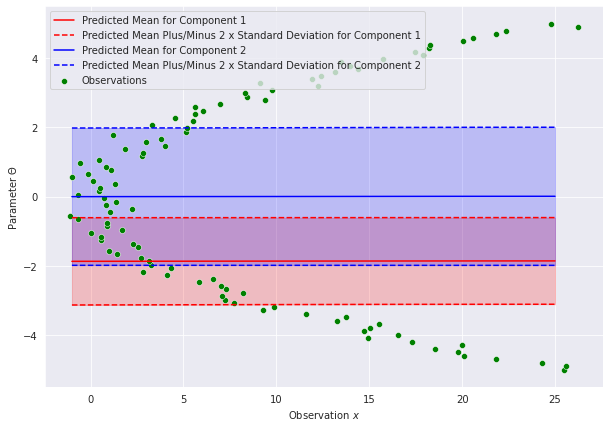

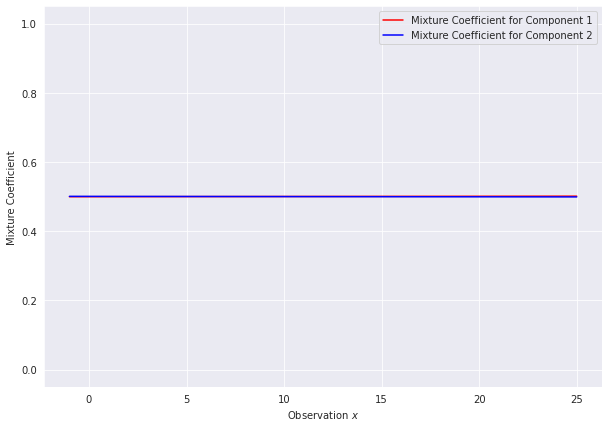

In [21]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [16]:
prngkey = jax.random.PRNGKey(20)
loss = losses.SELBO(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

Loss = 71.20814514160156, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.66413575,  0.07526125,  2.284388  ,  1.3232702 ,
               0.31232136]], dtype=float32), 'b_0': DeviceArray([-0.09999999, -0.09999999,  0.09999998, -0.09999997,
              0.09999999], dtype=float32), 'W_1': DeviceArray([[ 0.03433642, -0.56231135, -0.47581705, -0.31056714,
               0.3343586 ],
             [-0.29493076,  1.070614  , -1.1519593 ,  0.6010226 ,
              -0.00757471],
             [-0.37066457,  0.7379989 ,  0.21807295,  0.47774735,
              -0.43291187],
             [-0.12278593,  0.9858867 ,  0.87058413, -0.32911828,
              -0.8476601 ],
             [-1.1499256 ,  0.6971966 ,  1.115199  ,  0.670917  ,
               1.0498979 ]], dtype=float32), 'b_1': DeviceArray([ 0.1       , -0.09999999,  0.1       ,  0.1       ,
             -0.09999999], dtype=float32), 'W_2': DeviceArray([[ 0.20621264,  0.14695707,  0.9638821 , -0.677345  ,
              -0.912652

Loss = 59.517616271972656, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.54415375,  0.17979115,  2.1293447 ,  1.4551648 ,
               0.12007643]], dtype=float32), 'b_0': DeviceArray([-0.21248446, -0.19577517,  0.22087151, -0.15495898,
              0.14583035], dtype=float32), 'W_1': DeviceArray([[ 0.10448752, -0.6481916 , -0.3812829 , -0.21559656,
               0.15604329],
             [-0.23393074,  0.9858851 , -1.06055   ,  0.69109994,
              -0.19508147],
             [-0.33476055,  0.6603164 ,  0.30188322,  0.5558087 ,
              -0.63111657],
             [-0.07866766,  0.90443987,  0.95646447, -0.24769367,
              -1.0441858 ],
             [-1.1013726 ,  0.61934537,  1.2010559 ,  0.7546377 ,
               0.856636  ]], dtype=float32), 'b_1': DeviceArray([ 0.15800239, -0.18201782,  0.18981229,  0.18864411,
             -0.28848776], dtype=float32), 'W_2': DeviceArray([[ 0.11295591,  0.22658488,  1.0002363 , -0.77482986,
              -1.01986

Loss = 56.44472885131836, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.46436644,  0.24043836,  1.9534316 ,  1.5161768 ,
              -0.04015104]], dtype=float32), 'b_0': DeviceArray([-0.28495234, -0.23528028,  0.31503612, -0.10696351,
              0.09861149], dtype=float32), 'W_1': DeviceArray([[ 0.11377042, -0.67501646, -0.34045368, -0.17333099,
              -0.03050832],
             [-0.23734379,  0.9634275 , -1.0237787 ,  0.72667825,
              -0.3874845 ],
             [-0.3725648 ,  0.6592349 ,  0.32715946,  0.57385904,
              -0.82999015],
             [-0.10435934,  0.89239836,  0.98593485, -0.22384767,
              -1.2416697 ],
             [-1.1214632 ,  0.6101798 ,  1.2287772 ,  0.78069246,
               0.65937525]], dtype=float32), 'b_1': DeviceArray([ 0.14973292, -0.19931304,  0.22324803,  0.2213806 ,
             -0.48271897], dtype=float32), 'W_2': DeviceArray([[ 0.06532819,  0.22941715,  0.98172367, -0.8144026 ,
              -1.093440

Loss = 46.35679626464844, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.406271  ,  0.26782444,  1.7669555 ,  1.4894228 ,
              -0.18304215]], dtype=float32), 'b_0': DeviceArray([-0.3324511 , -0.2494588 ,  0.3940772 , -0.03021439,
              0.00385565], dtype=float32), 'W_1': DeviceArray([[ 0.11727722, -0.6810858 , -0.32552534, -0.15525311,
              -0.21421827],
             [-0.24508908,  0.9637885 , -1.0142261 ,  0.73661655,
              -0.5730458 ],
             [-0.40914273,  0.68626785,  0.32177588,  0.56307304,
              -1.0172409 ],
             [-0.13138159,  0.9068302 ,  0.9861518 , -0.22775133,
              -1.4274648 ],
             [-1.141915  ,  0.6239381 ,  1.2282399 ,  0.78088593,
               0.46791404]], dtype=float32), 'b_1': DeviceArray([ 0.13851315, -0.19366157,  0.22857054,  0.22798201,
             -0.67202175], dtype=float32), 'W_2': DeviceArray([[ 0.03098165,  0.1900866 ,  1.0035943 , -0.8266808 ,
              -1.152142

Loss = 40.12895584106445, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.36269465,  0.26952928,  1.5909547 ,  1.42677   ,
              -0.34664387]], dtype=float32), 'b_0': DeviceArray([-0.36299425, -0.25859392,  0.4508866 ,  0.02597829,
             -0.10683033], dtype=float32), 'W_1': DeviceArray([[ 0.13458931, -0.68689203, -0.3213965 , -0.14642455,
              -0.37408432],
             [-0.23311089,  0.9642665 , -1.0167028 ,  0.7365902 ,
              -0.7316466 ],
             [-0.4106433 ,  0.7083312 ,  0.30326593,  0.54257584,
              -1.1719984 ],
             [-0.12890808,  0.92009085,  0.9729244 , -0.24216549,
              -1.5819962 ],
             [-1.1383455 ,  0.63366556,  1.217472  ,  0.7734181 ,
               0.3024927 ]], dtype=float32), 'b_1': DeviceArray([ 0.149263  , -0.18981549,  0.22231989,  0.2252908 ,
             -0.8355575 ], dtype=float32), 'W_2': DeviceArray([[ 9.74587165e-04,  1.38339624e-01,  1.07547522e+00,
              -8.2827025

Loss = 38.61721420288086, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.31836596,  0.26269147,  1.4502084 ,  1.3756541 ,
              -0.52928007]], dtype=float32), 'b_0': DeviceArray([-0.38853517, -0.2699832 ,  0.5094369 ,  0.05433346,
             -0.18770352], dtype=float32), 'W_1': DeviceArray([[ 0.14881681, -0.69786674, -0.31528756, -0.1364027 ,
              -0.49618673],
             [-0.21813712,  0.9580863 , -1.0171075 ,  0.7385648 ,
              -0.85227317],
             [-0.40206683,  0.7145836 ,  0.29060262,  0.52888286,
              -1.286227  ],
             [-0.11544065,  0.92284167,  0.96279675, -0.25252095,
              -1.6982132 ],
             [-1.1346561 ,  0.6327569 ,  1.2123972 ,  0.77120763,
               0.17628062]], dtype=float32), 'b_1': DeviceArray([ 0.16135347, -0.19474147,  0.2200156 ,  0.22618026,
             -0.95965743], dtype=float32), 'W_2': DeviceArray([[-0.02440042,  0.1038246 ,  1.1345142 , -0.8307246 ,
              -1.234541

Loss = 38.08378982543945, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.27045473,  0.25566855,  1.3180298 ,  1.3436619 ,
              -0.7164813 ]], dtype=float32), 'b_0': DeviceArray([-0.41433358, -0.2807973 ,  0.5891721 ,  0.07167741,
             -0.21757078], dtype=float32), 'W_1': DeviceArray([[ 0.14029773, -0.7126358 , -0.30443776, -0.12343555,
              -0.5875032 ],
             [-0.22418731,  0.94662064, -1.0116373 ,  0.7450441 ,
              -0.9427443 ],
             [-0.42217875,  0.707721  ,  0.28935748,  0.5254732 ,
              -1.3698875 ],
             [-0.1227506 ,  0.91675675,  0.9610185 , -0.25534084,
              -1.7853004 ],
             [-1.1570345 ,  0.623914  ,  1.2159431 ,  0.77571994,
               0.08197337]], dtype=float32), 'b_1': DeviceArray([ 0.14798269, -0.2064645 ,  0.22534792,  0.23290166,
             -1.0519174 ], dtype=float32), 'W_2': DeviceArray([[-0.04411756,  0.09488887,  1.1331601 , -0.8378032 ,
              -1.265467

Loss = 37.715702056884766, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.22543688,  0.24990188,  1.1891654 ,  1.3219084 ,
              -0.8896979 ]], dtype=float32), 'b_0': DeviceArray([-0.43853077, -0.28940994,  0.67748773,  0.08669759,
             -0.2187093 ], dtype=float32), 'W_1': DeviceArray([[ 0.11794186, -0.72805727, -0.292113  , -0.11013556,
              -0.65888834],
             [-0.24482056,  0.93347615, -1.0035404 ,  0.7532273 ,
              -1.0135959 ],
             [-0.4632333 ,  0.6947782 ,  0.2943056 ,  0.5274992 ,
              -1.4344486 ],
             [-0.14656022,  0.906796  ,  0.96385944, -0.2541449 ,
              -1.8535365 ],
             [-1.1949847 ,  0.61195517,  1.2234176 ,  0.78298134,
               0.00844209]], dtype=float32), 'b_1': DeviceArray([ 0.11813292, -0.22056173,  0.23411363,  0.24188206,
             -1.1237563 ], dtype=float32), 'W_2': DeviceArray([[-0.05925687,  0.09929361,  1.0979455 , -0.8464024 ,
              -1.29186

Loss = 36.42995834350586, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.18671572,  0.24507862,  1.0731193 ,  1.3048768 ,
              -1.038794  ]], dtype=float32), 'b_0': DeviceArray([-0.45936802, -0.29622683,  0.75941193,  0.10039365,
             -0.21150118], dtype=float32), 'W_1': DeviceArray([[ 0.09429882, -0.7419115 , -0.2807444 , -0.09825505,
              -0.716677  ],
             [-0.267328  ,  0.92131716, -0.9955533 ,  0.7609912 ,
              -1.070973  ],
             [-0.5061778 ,  0.6813535 ,  0.30068615,  0.53098905,
              -1.486399  ],
             [-0.1726339 ,  0.8967811 ,  0.9678081 , -0.25187603,
              -1.9087969 ],
             [-1.2331641 ,  0.60039705,  1.2312633 ,  0.79024994,
              -0.05097706]], dtype=float32), 'b_1': DeviceArray([ 0.08693124, -0.23377474,  0.24293809,  0.25051838,
             -1.1818128 ], dtype=float32), 'W_2': DeviceArray([[-0.07130533,  0.10678666,  1.0575372 , -0.8541697 ,
              -1.313905

Loss = 36.6676025390625, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.15433685,  0.24102943,  0.97399426,  1.2909331 ,
              -1.1636077 ]], dtype=float32), 'b_0': DeviceArray([-0.4767835 , -0.30175993,  0.82991207,  0.11227082,
             -0.2032202 ], dtype=float32), 'W_1': DeviceArray([[ 0.07343885, -0.75370854, -0.27098837, -0.08816202,
              -0.7641302 ],
             [-0.28734145,  0.9108564 , -0.98855335,  0.7677194 ,
              -1.1180888 ],
             [-0.5441367 ,  0.66934764,  0.3066999 ,  0.53446406,
              -1.5289568 ],
             [-0.19585524,  0.88793004,  0.9715685 , -0.24959987,
              -1.9541707 ],
             [-1.2665442 ,  0.5903015 ,  1.2382767 ,  0.79666287,
              -0.09973072]], dtype=float32), 'b_1': DeviceArray([ 0.05944039, -0.24519259,  0.25072062,  0.2580363 ,
             -1.2294557 ], dtype=float32), 'W_2': DeviceArray([[-0.0811294 ,  0.11402828,  1.0211887 , -0.86070406,
              -1.3321722

Loss = 36.50185775756836, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.12743917,  0.23764461,  0.8909171 ,  1.2794079 ,
              -1.2673465 ]], dtype=float32), 'b_0': DeviceArray([-0.4912423 , -0.30630934,  0.8891309 ,  0.12229765,
             -0.19566946], dtype=float32), 'W_1': DeviceArray([[ 0.05582751, -0.76359165, -0.26279932, -0.0797191 ,
              -0.8033174 ],
             [-0.30427897,  0.9020555 , -0.982632  ,  0.7733903 ,
              -1.1569965 ],
             [-0.5762357 ,  0.65908116,  0.31192446,  0.53754175,
              -1.5640677 ],
             [-0.21551758,  0.880403  ,  0.9748407 , -0.24758397,
              -1.9916376 ],
             [-1.2946731 ,  0.58175325,  1.2442564 ,  0.8021079 ,
              -0.13997893]], dtype=float32), 'b_1': DeviceArray([ 0.03623305, -0.25481617,  0.25731972,  0.26438418,
             -1.2687902 ], dtype=float32), 'W_2': DeviceArray([[-0.0892202 ,  0.12032707,  0.99030644, -0.8661301 ,
              -1.3473  

Loss = 36.30104064941406, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.10511692,  0.23482533,  0.82167834,  1.2698585 ,
              -1.3534642 ]], dtype=float32), 'b_0': DeviceArray([-0.50323737, -0.3100695 ,  0.9385248 ,  0.13068156,
             -0.18916222], dtype=float32), 'W_1': DeviceArray([[ 0.04112132, -0.7718318 , -0.2559693 , -0.07268716,
              -0.8357646 ],
             [-0.3184365 ,  0.8947018 , -0.97767586,  0.7781301 ,
              -1.1892115 ],
             [-0.6030662 ,  0.65043056,  0.3163518 ,  0.54017365,
              -1.5931268 ],
             [-0.2319568 ,  0.8740801 ,  0.9776139 , -0.24586138,
              -2.0226586 ],
             [-1.3181509 ,  0.57458705,  1.2492802 ,  0.80667526,
              -0.17329945]], dtype=float32), 'b_1': DeviceArray([ 0.01685244, -0.26286453,  0.26284927,  0.26969445,
             -1.3013558 ], dtype=float32), 'W_2': DeviceArray([[-0.09591111,  0.1256555 ,  0.9644488 , -0.87062913,
              -1.359839

Loss = 36.593746185302734, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.08658879,  0.23248048,  0.7640706 ,  1.2619374 ,
              -1.4249591 ]], dtype=float32), 'b_0': DeviceArray([-0.51319164, -0.3131845 ,  0.97963446,  0.13766837,
             -0.18365805], dtype=float32), 'W_1': DeviceArray([[ 0.0288789 , -0.7786912 , -0.25028417, -0.066838  ,
              -0.86266893],
             [-0.33022824,  0.8885727 , -0.9735426 ,  0.78208035,
              -1.215923  ],
             [-0.6254157 ,  0.64318424,  0.32006943,  0.54239506,
              -1.617216  ],
             [-0.24565107,  0.8687939 ,  0.97994226, -0.2444085 ,
              -2.0483794 ],
             [-1.3376927 ,  0.56860244,  1.2534788 ,  0.81048954,
              -0.20092565]], dtype=float32), 'b_1': DeviceArray([ 7.1728881e-04, -2.6957613e-01,  2.6746351e-01,
              2.7412227e-01, -1.3283569e+00], dtype=float32), 'W_2': DeviceArray([[-0.10145523,  0.13012165,  0.9428928 , -0.8743608 ,
       

Loss = 36.38994216918945, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.07120618,  0.23053104,  0.7161724 ,  1.2553633 ,
              -1.4843248 ]], dtype=float32), 'b_0': DeviceArray([-0.5214549 , -0.31576815,  1.0138198 ,  0.14348197,
             -0.1790386 ], dtype=float32), 'W_1': DeviceArray([[ 0.01869889, -0.7843973 , -0.24555598, -0.06197517,
              -0.88499385],
             [-0.34003627,  0.88346976, -0.970101  ,  0.78536844,
              -1.2380877 ],
             [-0.64400744,  0.6371306 ,  0.32317796,  0.54425865,
              -1.6372021 ],
             [-0.2570426 ,  0.86438376,  0.9818887 , -0.2431904 ,
              -2.0697217 ],
             [-1.3539422 ,  0.5636131 ,  1.2569792 ,  0.81366855,
              -0.22384839]], dtype=float32), 'b_1': DeviceArray([-0.01270057, -0.27516603,  0.27130696,  0.27780896,
             -1.3507612 ], dtype=float32), 'W_2': DeviceArray([[-0.10605381,  0.13385063,  0.92495334, -0.8774573 ,
              -1.378878

Loss = 36.386810302734375, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.05843398,  0.22891048,  0.67636365,  1.2499063 ,
              -1.5336215 ]], dtype=float32), 'b_0': DeviceArray([-0.52831507, -0.31791234,  1.0422328 ,  0.14831476,
             -0.17517683], dtype=float32), 'W_1': DeviceArray([[ 0.01023884, -0.7891422 , -0.24162565, -0.05793371,
              -0.90352464],
             [-0.34818846,  0.8792238 , -0.9672381 ,  0.7881033 ,
              -1.2564852 ],
             [-0.6594618 ,  0.6320808 ,  0.325771  ,  0.54581696,
              -1.6537899 ],
             [-0.26651126,  0.8607088 ,  0.9835119 , -0.2421724 ,
              -2.0874364 ],
             [-1.3674463 ,  0.5594575 ,  1.2598938 ,  0.8163151 ,
              -0.24287473]], dtype=float32), 'b_1': DeviceArray([-0.02385193, -0.2798184 ,  0.27450502,  0.28087604,
             -1.3693573 ], dtype=float32), 'W_2': DeviceArray([[-0.1098699 ,  0.13695797,  0.91003716, -0.8800274 ,
              -1.38604

Loss = 36.4916877746582, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.04783019,  0.2275636 ,  0.6432891 ,  1.2453765 ,
              -1.5745525 ]], dtype=float32), 'b_0': DeviceArray([-0.53401   , -0.31969208,  1.0658387 ,  0.15232986,
             -0.17195517], dtype=float32), 'W_1': DeviceArray([[ 0.00321101, -0.79308635, -0.23835985, -0.05457596,
              -0.91890633],
             [-0.3549612 ,  0.8756927 , -0.96485806,  0.7903768 ,
              -1.2717563 ],
             [-0.67230195,  0.6278725 ,  0.3279311 ,  0.5471175 ,
              -1.6675578 ],
             [-0.2743778 ,  0.85764897,  0.9848638 , -0.24132323,
              -2.1021407 ],
             [-1.3786649 ,  0.5559987 ,  1.2623185 ,  0.8185168 ,
              -0.2586674 ]], dtype=float32), 'b_1': DeviceArray([-0.03311576, -0.2836883 ,  0.27716425,  0.28342614,
             -1.3847932 ], dtype=float32), 'W_2': DeviceArray([[-0.11303696,  0.13954437,  0.89764166, -0.88216054,
              -1.3919977

Loss = 36.32877731323242, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.03902883,  0.22644465,  0.6158194 ,  1.2416172 ,
              -1.6085289 ]], dtype=float32), 'b_0': DeviceArray([-0.5387365 , -0.32116908,  1.0854435 ,  0.15566407,
             -0.16927071], dtype=float32), 'W_1': DeviceArray([[-0.00262484, -0.7963636 , -0.23564728, -0.05178724,
              -0.9316717 ],
             [-0.36058563,  0.8727574 , -0.9628803 ,  0.7922659 ,
              -1.2844298 ],
             [-0.6829658 ,  0.6243679 ,  0.32972905,  0.5482017 ,
              -1.6789832 ],
             [-0.2809106 ,  0.8551028 ,  0.9859888 , -0.2406156 ,
              -2.114344  ],
             [-1.387981  ,  0.5531213 ,  1.2643344 ,  0.82034737,
              -0.2717736 ]], dtype=float32), 'b_1': DeviceArray([-0.0408086 , -0.2869059 ,  0.27937433,  0.28554538,
             -1.3976033 ], dtype=float32), 'W_2': DeviceArray([[-0.11566495,  0.14169559,  0.88734555, -0.8839306 ,
              -1.396936

Loss = 36.394744873046875, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.03172622,  0.2255155 ,  0.5930143 ,  1.2384986 ,
              -1.636722  ]], dtype=float32), 'b_0': DeviceArray([-0.54265785, -0.32239446,  1.1017183 ,  0.15843156,
             -0.1670357 ], dtype=float32), 'W_1': DeviceArray([[-0.00746885, -0.7990856 , -0.23339516, -0.04947206,
              -0.9422621 ],
             [-0.36525443,  0.87031835, -0.9612376 ,  0.793835  ,
              -1.294944  ],
             [-0.69181836,  0.62145084,  0.33122468,  0.54910487,
              -1.6884617 ],
             [-0.28633353,  0.8529851 ,  0.98692447, -0.24002634,
              -2.1244676 ],
             [-1.3957142 ,  0.55072886,  1.2660097 ,  0.8218686 ,
              -0.2826467 ]], dtype=float32), 'b_1': DeviceArray([-0.04719418, -0.28957993,  0.2812102 ,  0.2873058 ,
             -1.4082308 ], dtype=float32), 'W_2': DeviceArray([[-0.11784492,  0.14348383,  0.87879705, -0.8853989 ,
              -1.40103

Loss = 36.353004455566406, Params = Jaxtainer({'component_0': {'W_0': DeviceArray([[-0.0256699 ,  0.22474436,  0.57409066,  1.2359126 ,
              -1.6601056 ]], dtype=float32), 'b_0': DeviceArray([-0.54590976, -0.32341066,  1.1152223 ,  0.16072744,
             -0.16517617], dtype=float32), 'W_1': DeviceArray([[-0.01148762, -0.8013454 , -0.23152624, -0.0475509 ,
              -0.9510444 ],
             [-0.3691281 ,  0.8682927 , -0.9598739 ,  0.7951376 ,
              -1.3036631 ],
             [-0.6991636 ,  0.619024  ,  0.3324681 ,  0.54985684,
              -1.6963214 ],
             [-0.2908329 ,  0.85122466,  0.9877022 , -0.23953593,
              -2.132863  ],
             [-1.40213   ,  0.54874045,  1.2674011 ,  0.82313216,
              -0.2916632 ]], dtype=float32), 'b_1': DeviceArray([-0.05249203, -0.29180112,  0.28273448,  0.2887674 ,
             -1.4170437 ], dtype=float32), 'W_2': DeviceArray([[-0.11965249,  0.1449695 ,  0.87170315, -0.8866164 ,
              -1.40443

KeyboardInterrupt: 

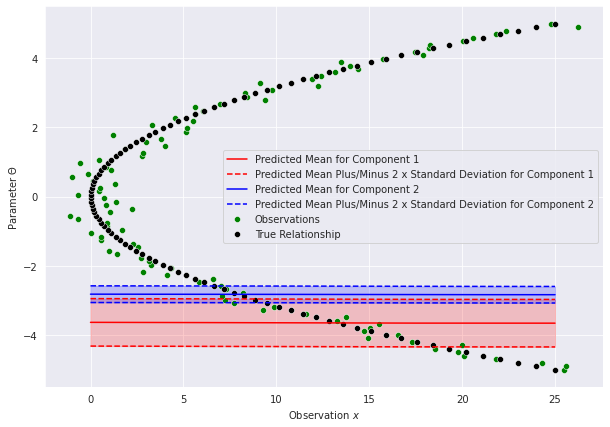

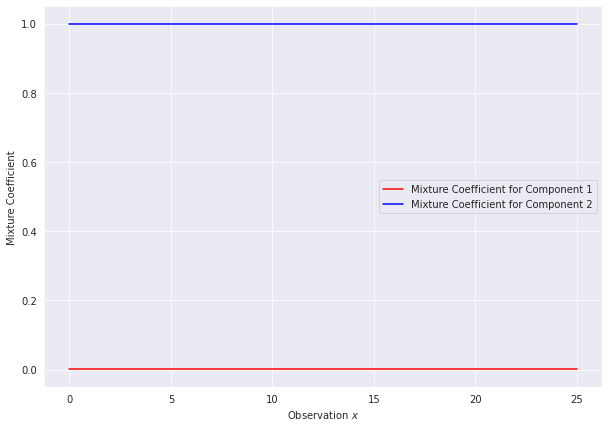

In [17]:
x_plt = jnp.linspace(0,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

In [16]:
amortised_dist.add_component()

NameError: name 'copy' is not defined

In [ ]:
x_vals = jnp.linspace(-5,25,7)
plot_posteriors(amortised_dist, x_vals)

# Linear Regression

In [ ]:
prngkey = jax.random.PRNGKey(10)
approx_dist = approx.Gaussian(ndim)
preprocessing = amortised.Preprocessing.range_scaling(data)
amortised_dist = amortised.LinearRegression(approx_dist, ndim, prngkey, order=20, preprocessing=preprocessing)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [ ]:
amortised_dist.initialise(data)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta)

In [ ]:
prngkey = jax.random.PRNGKey(42)
loss = losses.ReverseKL(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True, num_samples=1000, max_iter=200)

In [ ]:
x_plt = jnp.linspace(-1,25,1000)
plot_phi_function(amortised_dist, x_plt, data, true_theta, model)

In [ ]:
x_vals = [0, 1, 2, 3, 4, 5]
plot_posteriors(amortised_dist, x_vals)